# Axes Detection

This code gives a best estimate of the x and y axis (horizontal and vertical axes) for the plot/chart.

In [1]:
import cv2, imutils
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import rcParams

In [2]:
# Directory of images to run the code on
img_dir = 'test'

# Directory to save the output images
save_dir = 'out'

### Method to separate horizontal and vertical lines.

In [3]:
def segmentLines(lines, threshold = 10):
    hlines, vlines = [], []
    
    for line in lines:
        for (point1x, point1y, point2x, point2y) in line:
            # If x-values are near (i.e., within a threshold),
            # then the lines are vertical. Similarly, if y-values
            # are near, then the lines are horizontal. 
            
            if abs(point2x - point1x) < threshold:
                vlines.append(line)
            elif abs(point2y - point1y) < threshold:
                hlines.append(line)
    
    return hlines, vlines

### Function to detect x-axis and y-axis for a plot

In [4]:
def DetectAxes(filepath):
    if filepath is None:
        return None, None
    
    image = cv2.imread(filepath)
        
    # Convert the image to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    # Compute the Scharr gradient magnitude representation of
    # the images in both the x and y direction using OpenCV 2.4
    ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
    gradX = cv2.Sobel(gray, ddepth = ddepth, dx = 1, dy = 0, ksize = -1)
    gradY = cv2.Sobel(gray, ddepth = ddepth, dx = 0, dy = 1, ksize = -1)
        
    # Subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    # Blur and threshold the image
    blurred = cv2.blur(gradient, (9, 9))
    _, thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(gray, 50, 150, apertureSize = 3) 
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold = 200, maxLineGap = 20, minLineLength = 50)
    
    # No lines detected
    if lines is None:
        return None, None
        
    # Segment the lines into horizontal and vertical
    h_lines, v_lines = segmentLines(lines, 10)

    # There are either no horizontal or vertical lines, return None
    # May be pie charts or not a plot, check further later.
    if len(h_lines) == 0 or len(v_lines) == 0:
        return None, None
        
    try:         
        y1_vals = [l[0][1] for l in h_lines]
        idx_max_y1 = y1_vals.index(max(y1_vals))
        xaxis = h_lines[idx_max_y1]
            
        x1_vals = [l[0][0] for l in v_lines]
        idx_min_x1 = x1_vals.index(min(x1_vals))
        yaxis = v_lines[idx_min_x1]
        
        return xaxis, yaxis
        
    except IndexError:
        return None, None

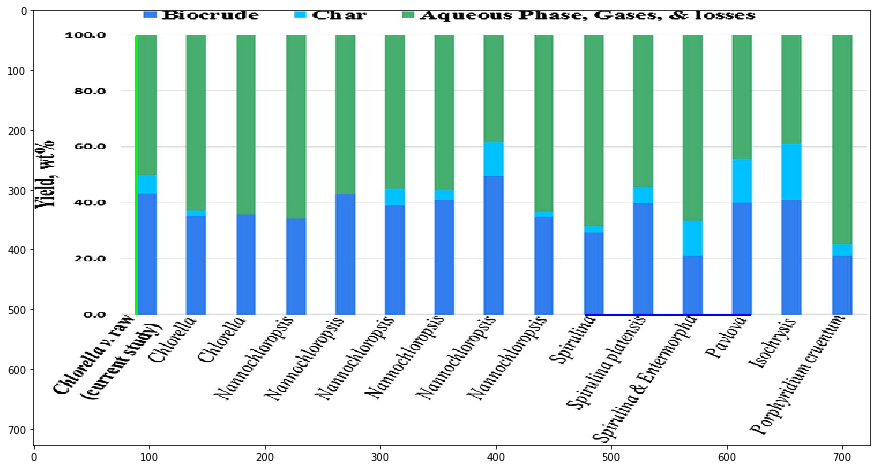

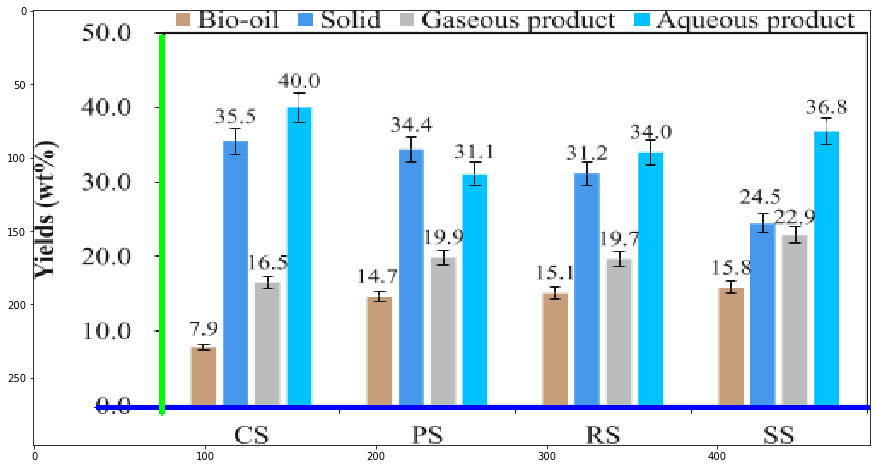

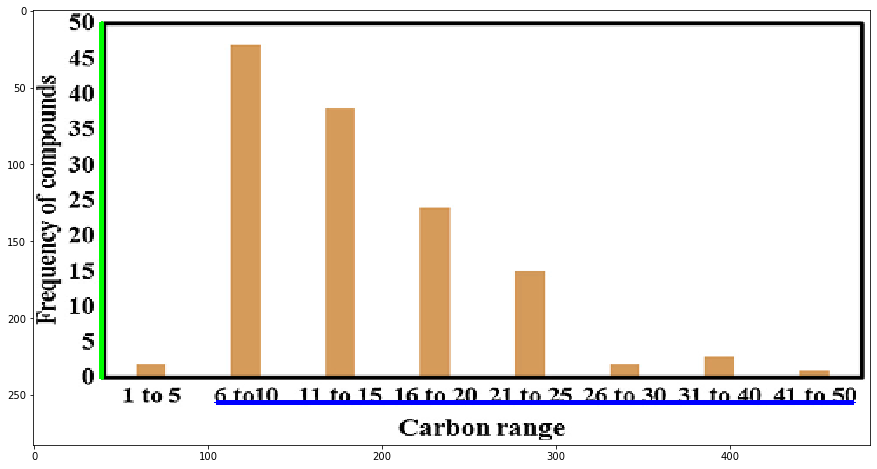

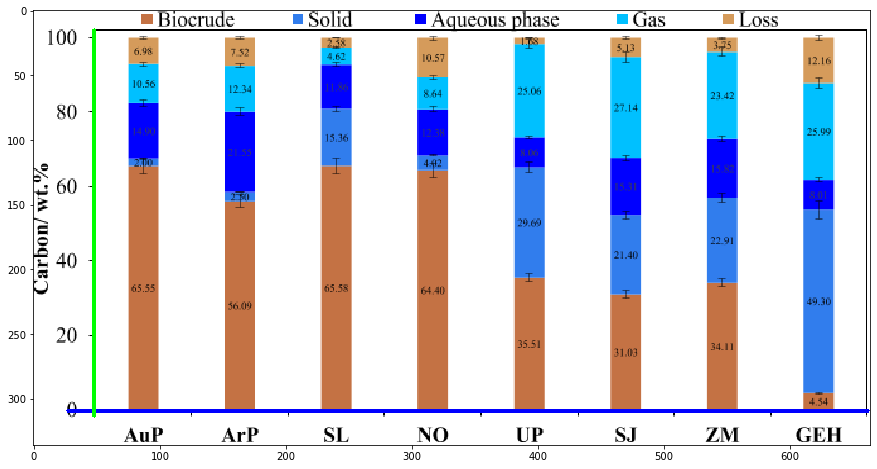

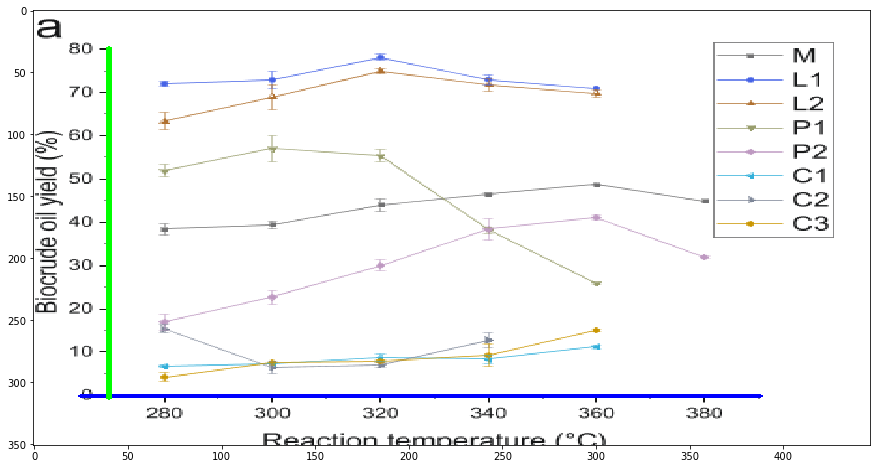

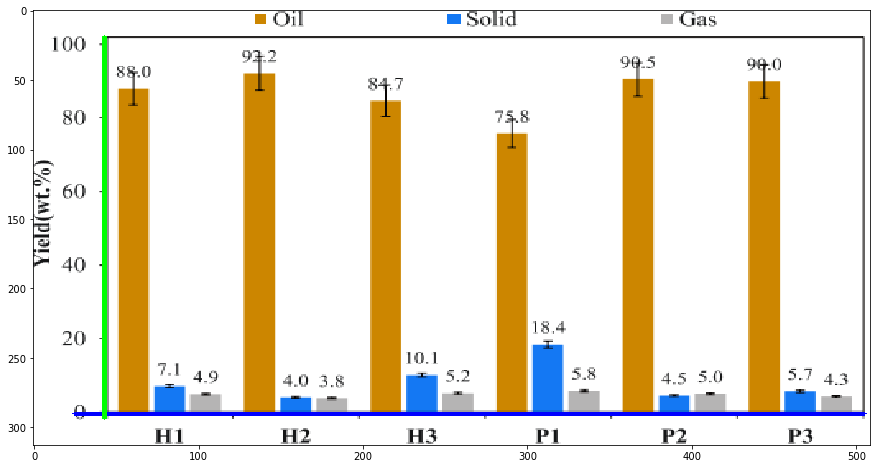

In [5]:
for path in Path(img_dir).iterdir():
    if path.name.endswith('.png') or path.name.endswith('.jpg'):

        filepath = img_dir + "/" + path.name
        image = cv2.imread(filepath)
        xaxis, yaxis = DetectAxes(filepath)
        
        if xaxis is None or yaxis is None:
            continue

        for line in [xaxis]:
            for (x1, y1, x2, y2) in line:
                cv2.line(image, (x1, y1), (x2, y2),  (0, 0, 255), 2)

        for line in [yaxis]:
            for (x1, y1, x2, y2) in line:
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        rcParams['figure.figsize'] = 15, 8

        fig, ax = plt.subplots(1, 1)

        ax.imshow(image, aspect = 'auto')
        cv2.imwrite(save_dir + '/' + ''.join(path.name.split(".")[:-1]) + "_axes.png", image)        